# Analysis of time series  in practice

## <span style="color:blue;">**Classical time series analysis**</span>

**Authors**: Ivan Nazarov @ivanz, Evgenya Romanenkova, Alexey Zaytsev

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm

In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# <span style="color:blue;">**Seminar 1**</span>

#### Seminar 1. 

1. Data preprocessing:

    1. Visualization of trends
    2. Filling missing values
    3. Preparation of training and test samples
    
    
    
2. Test for stationarity:

    1. Rolling characteristics
    2. Correlation analysis
    3. Testing hypotheses for stationarity of random process

## Time series analysis is useful for...

- compressed **dynamics description** of the observed processes

- dynamics interpretation and **impulse response estimation**

- **forecasting** and simulation

- solving **optimal control** problems

<br>

## Problem statement of time series analysis

Building a time series model for the *current value* **of the endogenous** variable $y_t$

* from its *previous history* $y_{:t} = (y_{t-1}, y_{t-2}, \ldots)$

* *current value* **of the exogenous** variable $x_t$ and perhaps *their previous history* too


$$
    y_t \approx \text{model}\bigl( t,\, y_{:t},\, x_t,\, x_{:t} \bigr)
\,. $$

<!-- You can consider forecasting tasks several steps ahead of the current value, but the most commonly is using prediction one step ahead. -->

<br>

## Differences from other machine learning tasks

* Data is sequential:

  - the order of **time** must be strictly kept in order to save causality

* Great focus on **extrapolation**, i.e. a forecast for the future relative to the available sample
  
  - <span style="color:blue;">**IMPORTANT**</span> to make sure that <span style="color: blue;"> **there is no "leakage" of information "from the future"** </span> while generating features and building a model.

Therefore, features in the model can only depend on
* **endogenous** variable $y_{t-1}, y_{t-2}, \ldots$, available at the time of $t-1$ *inclusive*;
* **exogenous** variable $x_t, x_{t-1}, \ldots$, available at the time of $t$ *inclusive*;

<br>

#### А. Loading and visualizing data

Load the time series of the $CO_2$ concentration in the atmosphere  (based on the data [from here](https://www.co2.earth/weekly-co2)).

In [7]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [8]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


While loading a time series in Pandas, you must explicitly indicate the transformation of label from the string to date-time.

* You can also specify the transformation during the call of `pd.read_csv`

In [9]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

Rename the columns

In [10]:
dataset = dataset.rename(columns={"date": "date", "WMLCO2": "CO2 concentration"})

In [11]:
dataset.head()

,date,CO2 concentration
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


Create an index for the uploaded data: it is a **weekly periodic index**

We obtain data with a regular frequency.

In [12]:
dataset = dataset.set_index("date").to_period("W")

In [13]:
dataset.head()

,CO2 concentration
date,
1958-03-24/1958-03-30,316.1
1958-03-31/1958-04-06,317.3
1958-04-07/1958-04-13,317.6
1958-04-14/1958-04-20,317.5
1958-04-21/1958-04-27,316.4


Plot the dynamics of the series

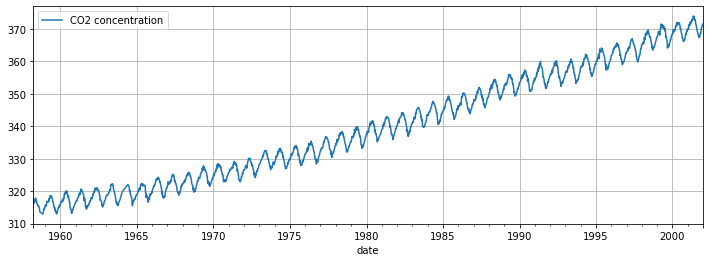

In [14]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Let's aggregate weekly data to monthly data

In [15]:
dataset = dataset.to_timestamp()

dataset = dataset.resample("M").mean()

In [16]:
dataset.head()

,CO2 concentration
date,
1958-03-31,316.700
1958-04-30,317.100
1958-05-31,317.700
1958-06-30,315.800
1958-07-31,315.575


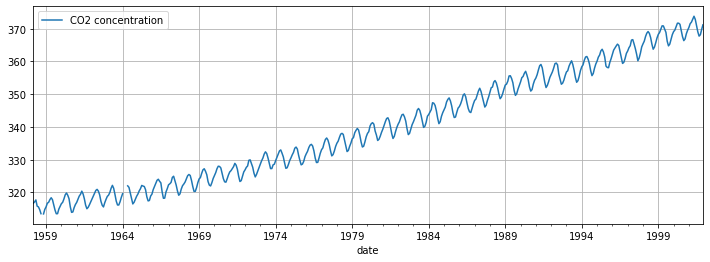

In [17]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Let's look through the summary statistics of the series:

In [18]:
print("Series {1}, Observations {0}".format(*dataset.shape))

dataset.describe().T.head()

Series 1, Observations 526


,count,mean,std,min,25%,50%,75%,max
CO2 concentration,522.0,339.794055,17.090851,313.425,324.185,337.9825,354.545,373.825


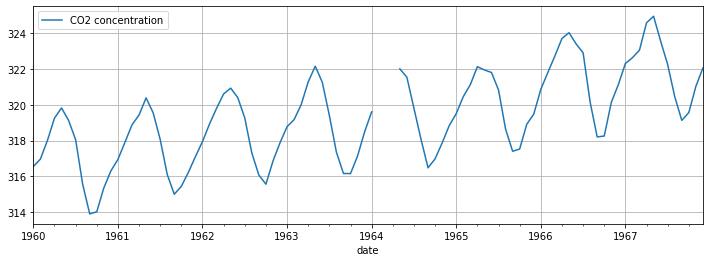

In [19]:
dataset.loc["1960":"1967"].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

#### В. Filling missing values

In [20]:
maginfy_slice = slice("1960", "1967")

You can remove missing values in time series:

1) By filling the last known value:

   -  **+** doesn't look "into the future"
   
   -  **-** cannot fill the empty values at the beginning of a series
   
   -  **-** doesn't take into account peculiarities of the series

Choose the `ffill` method to extrapolate the previous series values to the missing value. You can choose other standard methods, use the `Ctrl`+`Tab` to see the help

In [21]:
dataset_ff = dataset.fillna(method="ffill")

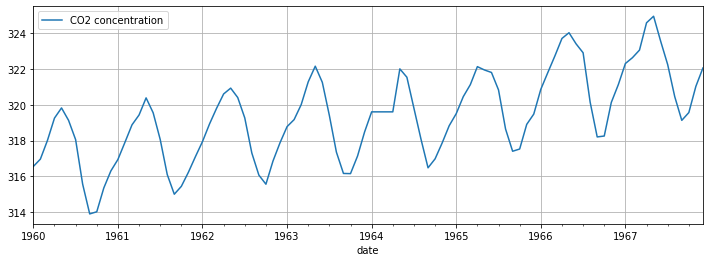

In [22]:
dataset_ff.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

2) By interpolation of neighboring observable values:

  + **+** smoothes out the outliers in the values

  - **-** doesn't allow to fill empty values at the ends of series
  
  + **-** looks "into the future"

In [23]:
dataset_linterp = dataset.interpolate(method='linear')

dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

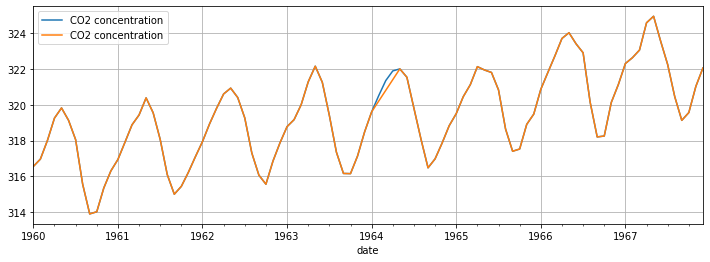

In [24]:
ax = dataset_pinterp.loc[maginfy_slice].plot(figsize=(12, 4))

dataset_linterp.loc[maginfy_slice].plot(ax=ax)

plt.grid(which="major", axis="both")

3) Exclude all missing values from the dataset:

  + **+** doesn't add distortion to values
  
  - **-** violates the regularity and relative periodicity

  - **-** reduce size of the dataset

In [26]:
dataset_drop = dataset.dropna()

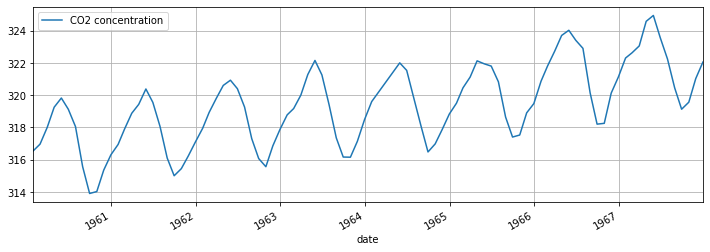

In [27]:
dataset_drop.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

4) Evaluate with a probabilistic model:

  + **+** filling in based on learned patterns
  
  - **-** need to specify the model and train it

5) Smooth with splines or a local kernel model:

  + **+** clearly taken into account the proximity of observations over time

  + **+** can increase the frequency of series observations ("resolution")

  + **+** can fill the gaps "on the edges"

  - **-** looks deep "into the future"
  
  - **-** requires kernel selection and an explicit model for extrapolation

The problem of looking into the future in methods 2 and 4 **can be ignored if the missing values are few**.

* <span style="color:blue;">**IMPORTANT**</span> If there are plenty of them, it is necessary to understand the origin of missing values.

In [28]:
full_dataset = dataset_pinterp

 ### B. Preparation of training and test samples

Let's prepare a training sample and a test sample with the ratio of 3 to 1

In [29]:
holdout = full_dataset.loc["1991-01-01":]

dataset = full_dataset.loc[:"1990-12-31"]

print(len(dataset), len(holdout))

394 132


Make sure the parts don't overlap

In [30]:
pd.concat([
    dataset.tail(),
    holdout.head()
], axis=1)

,CO2 concentration,CO2 concentration
date,,
1990-08-31,352.250,NaN
1990-09-30,350.950,NaN
1990-10-31,351.400,NaN
1990-11-30,353.075,NaN
1990-12-31,354.260,NaN
1991-01-31,NaN,354.925
1991-02-28,NaN,355.950
1991-03-31,NaN,357.400
1991-04-30,NaN,358.700


Explicitly save the intervals boundaries

In [32]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Training samples from {} to {}".format(*dataset.index[[0, -1]]))

print("Test samples from {} to {}".format(holdout_slice.start, holdout_slice.stop))

Training samples from 1958-03-31 00:00:00 to 1990-12-31 00:00:00
Test samples from 1991-01-31 00:00:00 to 2001-12-31 00:00:00


Set the target column

In [33]:
target_column = "CO2 concentration"

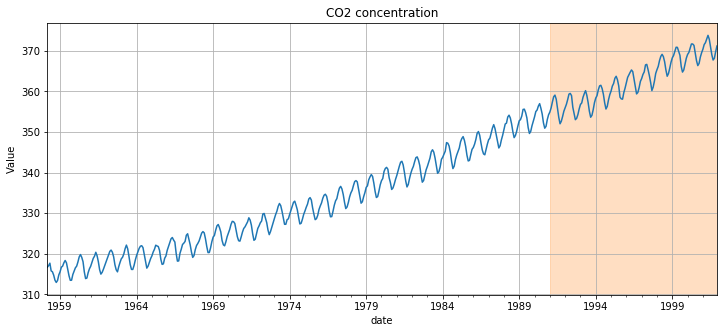

In [34]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="Value", title=target_column)

# plot the dynamics of the entire series
full_dataset[target_column].plot(ax=ax)

# emphasize the holdout interval
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;


<br>

## 2. Examination of the processes stationarity:

**Stationarity** -- a useful property of the process $\{y_t\}_{t\geq0}$, meaning that
> probabilistic relationships in a set $(y_{t_1},\,\ldots,\,y_{t_m})$ exactly the same as 
in a set $(y_{t_1+s},\,\ldots,\,y_{t_m+s})$, for any shift $s \neq 0$.

* there are no **specific time moments** when statistical properties of observations change;


* patterns are stable over time and are determined only by the **observations indents relative to each other**;
    * mean, variance, and autocorrelations do not depend on the moment of time;

### Stationarity - property ... what doesn't exist

Stochastic processes occur in real problems **are almost always non-stationary**.

* the mean value depends on the time (trend in the dynamics)
    - sustained GDP growth
    - reduction of production in the oil well
    - dependence on external factors (exogenous variables)

* calendar event
    - state and religious holidays

* seasonal periodicity
    - intraday cycling of electricity consumption
    - seasonal temperatures
    - annual peaks of monthly inflation in January-February

* periods of conservative dynamics are replaced by periods of relatively high volatility
    - strong perturbations in financial markets during the crisis

* unpredictable structural shifts and market changes
    - political decision
    - hardware failure
    - hysteresis

Thus, great part of time series, especially economic, climate, and financial ones, are **non-stationary.**

<br>

#### Visualization and diagnostics of non-stationarity

Visualization in time series analysis allows to:

- to obtain a preliminary understanding of the correlation patterns

- choose an appropriate validation strategy

- estimate the presence of structural changes in the time series dynamics
    * outliers and breaks
    * periods of intense fluctuations and periods of smooth movements

- to diagnose non-stationarity: the presence of a trend, seasonality, etc.

###   А. Rolling characteristics

Rolling statistics of the series in the window with length $N$ let find changes over time

* **rolling mean:** mean value of recent interval
$$
    m_t = \frac1{N} \sum_{s=t-N+1}^t y_s
\,; $$

* **rolling standard deviation:** spread or volatility
$$
    s_t = \sqrt{s^2_t}
        \,, \quad
    s^2_t = \frac1{N-1} \sum_{s=t-N+1}^t (y_s - m_t)^2
\,; $$

Procedure for easily plotting diagnostics below.

In [29]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Rolling mean", xlabel="Date", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Rolling std",
                                sharex=ax_top, xlabel="Date", ylabel="std")

    # draw plots:
    # series and rolling mean
    rolling.mean().plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # rolling std
    rolling.std().plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

Using rolling statistics we can get an idea about the presense of a trend in dynamic.

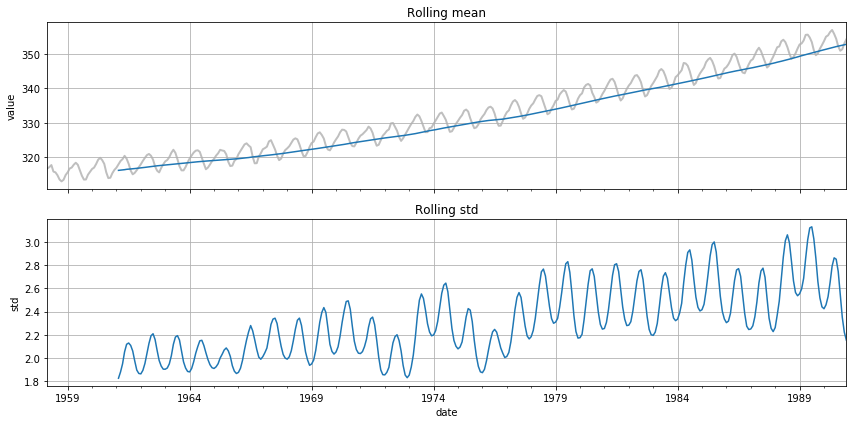

In [30]:
rolling_diagnostics(dataset[target_column], window=36);

<br>

###  Rough estimate of seasonality

Let's try explore seasonality, such as monthly or weekly.

* while evaluating seasonality, it is desirable to make seasonal correction relatively to the trend.

In [31]:
sm.api.nonparametric.lowess?

In [32]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):

    # use nonparametric local linear regression for preliminary trend estimation
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # group by month and calculate the mean and std
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Date")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # draw plots:
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% normal confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

The graphs show that there is seasonal periodicity in the dynamics

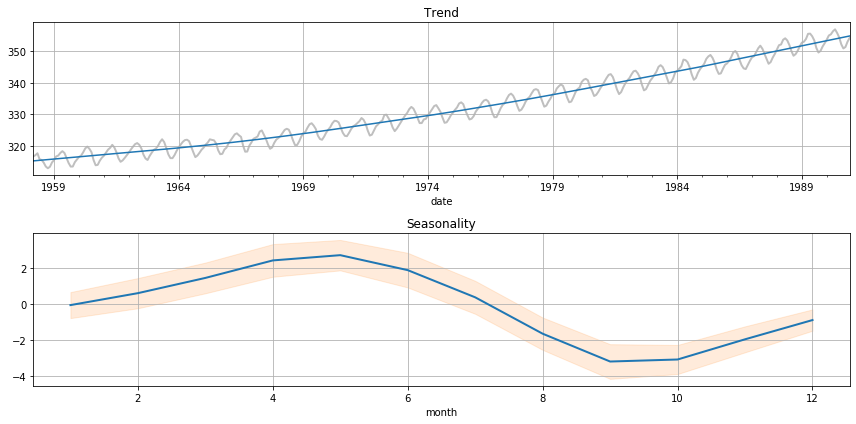

In [33]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period="month");

<br>

### B. Correlation analysis

#### Autocorrelation  and partial autocorrelation

These functions evaluate the effect of observing $h$ steps on the current observation, but do it in different ways:

* **autocorrelation** $\rho_h$ <!-- ($y_t \sim y_{t-h}$) -->
  - reflects the **aggregate** effect of $y_{t-h}$ on $y_t$ ** through** influence on all intermediate $y_{t-j}$, $j=1,\,...,\,h-1$

* **partial autocorrelation** $\phi_h$ <!-- ($y_t \sim y_{t-1}, \ldots, y_{t-h}$) -->
  - shows **pure** effect $y_{t-h}$ on $y_t$ **except** impact on the intermediate $y_{t-j}$, $j=1,\,...,\,h-1$

In [34]:
from statsmodels.tsa.stattools import acf, pacf

Procedure for easily plotting diagnostics below.

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def correlation_diagnostics(series, lags=60):
    # create and customize the figures: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # draw plots using function from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)

    fig.tight_layout()
    return fig

Let's explore sample autocorrelations of our series

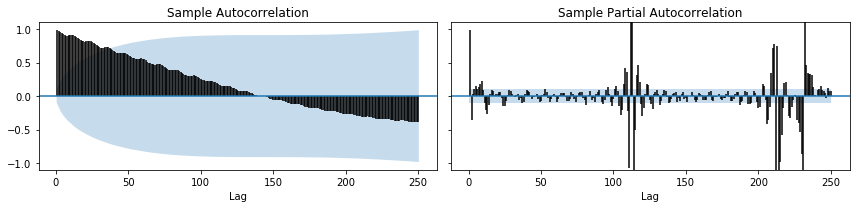

In [36]:
correlation_diagnostics(dataset[target_column], lags=250);

* on the *left plot* autocorrelation of small lags is close to $1.0$ and decreases quite slowly
* on the *right plot*, a statistically non-zero effect has an observation with a lag of 1

These are symptoms of the most typical type of non-stationarity -- presence of a dependency $y_t = y_{t-1} + \ldots$.

So, it seems that there is a strong dependence on the process history.

<br>

### C. Testing hypotheses for processes stationarity

#### Statistical diagnostics of non-stationarity

There are two types of trend in time series
* **determenistic trend** -- when noise or time deviations do not affect values in the long prospect 

* **stochastic trend** -- noise or unexpected shocks affect the entire future trajectory

For example, linear trends
\begin{aligned}
    & \text{Trend}
      & & \text{levels}
          & & \text{residuals}
        \\
    & \text{determenistic}
      & y_t
        &= y_1 + \delta \, t + \varepsilon_t
          & & y_t - y_{t-1} = \delta + \varepsilon_t-\varepsilon_{t-1}
    \,, \\
    & \text{stochastic}
      & y_t
        &= y_1 + \delta \, t + \sum_{s=1}^t \varepsilon_s
          & & y_t - y_{t-1} = \delta + \varepsilon_t
    \,,
\end{aligned}

#### KPSS

If suspect a **deterministic** linear trend, use the **KPSS test**: test the hypothesis $H_0\colon \sigma^2 = 0$ in the model


$$
    y_t = \alpha + \beta t + u_t + \nu_t
        \,, \quad
    u_t = u_{t-1} + \varepsilon_t
        \,, \quad
    \varepsilon_t \sim D(0, \sigma^2)
\,. $$

In [35]:
from statsmodels.tsa.stattools import kpss

In [36]:
kpss?

#### ADF

If suspect a **deterministic** linear trend, use the **KPSS test**: test the hypothesis $H_0\colon \sigma^2 = 0$ in the model

If suspect a **stochastic** trend, use the **Augmented Dickey-Fuller unit root test**: test the hypothesis $H_0\colon \gamma = 0$ in the model
$$
    \Delta y_t
        = \beta + \gamma y_{t-1}
            + \sum_{k=1}^{p-1} \phi_k \Delta y_{t-k}
            + \varepsilon_t
\,, $$
where $\Delta y_t = y_t - y_{t-1}$ -- first residual.

Alternatively, you can use the Phillips-Perron test.

In [39]:
from statsmodels.tsa.stattools import adfuller

\begin{aligned}
    & \text{ - }
      & & \text{ADF doesn't reject $H_0$ }
          & & \text{ADF reject $H_0$ }
    \,,    \\
    & \text{KPSS doesn't reject $H_0$ }
      & & \text{Not enough data *}
          & & \text{Deterministic trend} 
    \,, \\
    & \text{KPSS reject $H_0$ }
      & & \text{Stochastic trend} 
          & & \text{ ** }
    \,,
\end{aligned}

<!-- [Four cases](https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests/239367) --
<!--http://web.econ.ku.dk/metrics/Econometrics2_05_II/Slides/08_unitroottests_2pp.pdf-->

\* It is better, just in case, to take the first residual (there may be a high persistence).

** There can be anything: seasonality, heteroscedasticity, structural shifts, a weak but non-zero stochastic trend.

The procedure that returns text statistics and the corresponding $p$-value:

In [40]:
def stat_test_diagnostics(series):
    return {
        "ADF": adfuller(series, regression="ct")[:2],
        "KPSS": kpss(series, regression="c")[:2],
    }

In [41]:
stat_test_diagnostics(dataset[target_column])

{'ADF': (-1.5871756923514413, 0.7974141230613454),
 'KPSS': (2.2577203115669136, 0.01)}

All diagnostics in one procedure:

In [42]:
def diagnostics(series, window=250, fraction=0.25, lags=250):
    # rolling statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelations
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()

    return stat_test_diagnostics(series)

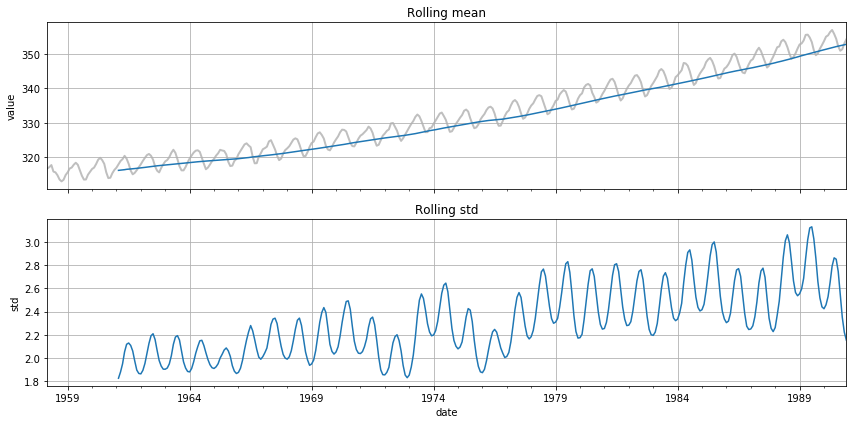

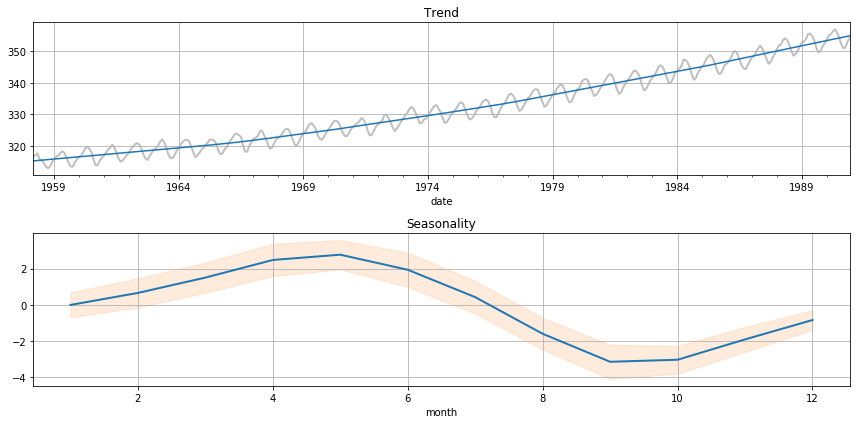

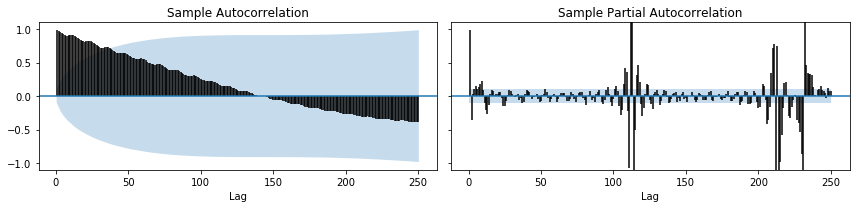

{'ADF': (-1.5871756923514413, 0.7974141230613454),
 'KPSS': (2.2577203115669136, 0.01)}

In [43]:
diagnostics(dataset[target_column], window=36)

### Problem

It is very difficult to model series **without stationarity**
 * there are no stable invariant patterns suitable for modeling and forecasting

### What should we do?

In time series analysis, everything is as in optimization problems
* successfully solved problems of **convex ** programming
* but all interesting practical problems are **non-convex**

If **approximate** the series as close as possible to the stationary one, **taking into account the trend, seasonality and other spoiling factors**, we **can hope for** more or less successful **modeling and solving** application problems.

<br>

# <span style="color:blue;">**Seminar 2**</span>

   
#### Seminar 2. 
    
3. Building a time series model:
    1. Bringing data to a stationarity one
    2. Holt-Winters model  of trend and seasonality 
    3. Validation of the time series model (evaluation metrics)    

#### Key stage

`I`. **Make time series stationary** using
  * transformations
    - $y \mapsto \log{y}$, $y \mapsto \frac{y^q - 1}{q}$, or $y \mapsto \sqrt{y}$;
    - shift and scaling

  * taking consecutive or seasonal residuals  

  * extraction and subtraction of trends/seasonalities

  * identification of special dates or events
    - state and religious holidays
    - moments of equipment replacement
    - crossing the rock type border.

* test hypotheses about the type of trend and seasonality
    * **deterministic** -- it is enough to evaluate it and then subtract it
    * **stochastic** -- it is necessary to take consecutive / seasonal differences of the series
  * e.t.c.

<span style="color:blue;">**IMPORTANT**</span> inverse transformation should be applied to forecasts in **inverse** order!

`II`. **Estimate the model parameters**
  * Maximizing likelihood, minimizing the $L^2$ loss function or empirical risk, etc.
  * take into account the heteroscedasticity and autocorrelation effects

`III`. **Visualization of differences**
  * look at the dynamics of the series, autocorrelations and partial autocorrelations, moving statistics

  * check residuals for model specification requirements

    - *acceptable* no autocorrelation

    - *acceptable* constant mean and std

`IV`. **Model validation**

  * validation of the model by an appropriate method (in accordance with the usage scenario)

  * calculation **forecasts on holdout** dataset

The time series modeling strategy is based on the ideas described in this paper

* Box, George; Jenkins, Gwilym (1970). *Time Series Analysis: Forecasting and Control.* San Francisco: Holden-Day.

##### All models are wrong, but some are useful

> Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration ... he should seek an economical description of natural phenomena.

George E. P. Box (1976), "Science and Statistics", *Journal of the American Statistical Association,* **71**, 791-799, DOI: [10.1080/01621459.1976.10480949](https://doi.org/10.1080/01621459.1976.10480949)

In practice, the time series should be updated and retrained when sufficient amount of new data is available.

As with any simulation, time series model should include only the necessary components, and then aim for the simplest model (`parsimony`).

####  А. Bringing data to a stationary view

In [37]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler

Our series is positive, so we will take logarithms and subtract the average

In [45]:
from sklearn.pipeline import Pipeline

transformer = Pipeline([
    ("Logarithm", FunctionTransformer(func=np.log, inverse_func=np.exp),),

    ("Scaling", StandardScaler(),),
])

In [46]:
transformer

Pipeline(memory=None,
         steps=[('Logarithm',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<ufunc 'log'>, inv_kw_args=None,
                                     inverse_func=<ufunc 'exp'>, kw_args=None,
                                     validate=False)),
                ('Scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

Transformation

In [47]:
log_dataset = pd.DataFrame(transformer.fit_transform(dataset),
                           columns=dataset.columns,
                           index=dataset.index)

In [48]:
log_dataset.head()

,CO2 concentration
date,
1958-03-31,-1.296455
1958-04-30,-1.261055
1958-05-31,-1.208038
1958-06-30,-1.376270
1958-07-31,-1.396259


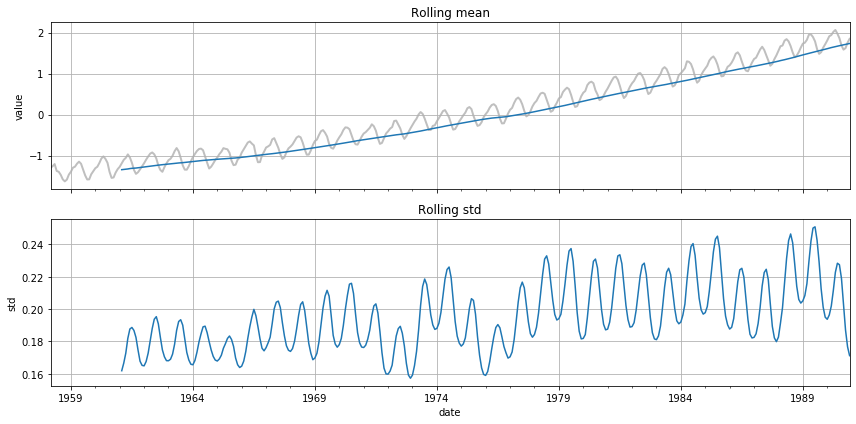

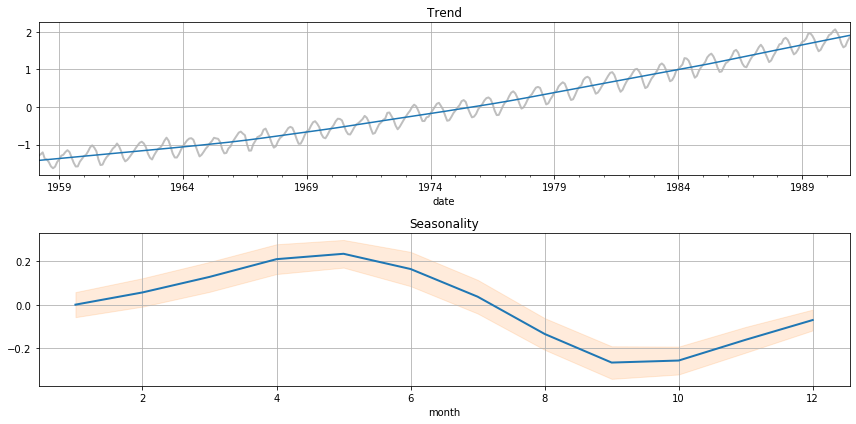

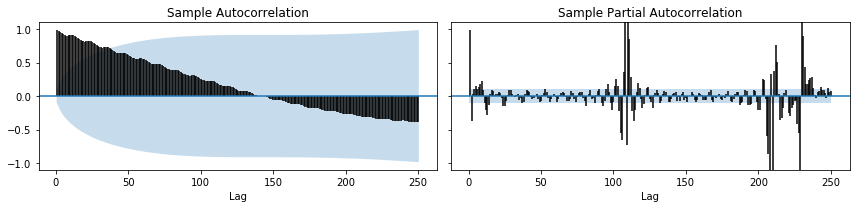

{'ADF': (-1.8153609109553404, 0.6973047105181185),
 'KPSS': (2.264517786224465, 0.01)}

In [49]:
diagnostics(log_dataset[target_column], window=36)

The transformation did not make any significant changes, but usually taking logarithms makes the estimation of model parameters more stable.

Transform the training sample in advance

In [50]:
train = transformer.fit_transform(dataset.values)

train = pd.DataFrame(train, index=dataset.index, columns=dataset.columns)

### B. Holt-Winters model  of trend and seasonality 

Generalized exponential smoothing with local linear trends and seasonality

* **+** simple model based on simple ideas

* **-** usually the selected trend is a little " late"

* **-** deterministic period of seasonality set manually

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

The forecast of the value $y_{t+h}$ for $h$ steps forward from the moment $t$ has the form

$$
    \hat{y}_{t+h\mid t}
        = l_t + h b_t + s_{t - m + h^+_m}
        \,, \quad
    h^+_\pi
        = 1 + \bigl((h - 1) \!\!\! \mod m\bigr)
\,, $$

where
* $m$ -- the period of seasonal cycle, $h^+_m$ the index of the seasonal effect

* Local *level* of the series $l_t = \alpha (y_t - s_{t-m}) + (1 - \alpha) (l_{t-1} + b_{t-1})$

* Local *trend slope* $b_t = \beta (l_t - l_{t-1}) + (1 - \beta) b_{t-1}$

* *Periodic* effects $ s_t = \gamma (y_t - (l_{t-1} + b_{t-1})) + (1 - \gamma) s_{t-m}$

Parameters are evaluated by solving the problem of minimizing *standard deviation*
$\hat{y}_{t+1\mid t}$ from $y_{t+1}$:

* $\alpha$, $\beta$ and $\gamma$
* the initial effects of seasonality $s_1,\,\ldots,\,s_m$
* the initial level and the slope coefficient $l_1$ и $b_1$

In [52]:
exp_smooth = ExponentialSmoothing(train,
                                  trend="add",         # additive trend
                                  seasonal="add",      # additive seasonality
                                  seasonal_periods=12)

exp_smooth_fitted = exp_smooth.fit(remove_bias=True)

If there is no seasonality ($s_t=0$) and slope ($b_t = 0$) then

* for $\alpha \approx 1$ the forecast $\hat{y}_{t+h\mid t}$ with the value $y_{t+h}$ is $y_t$

* for $\alpha\approx 0$ the forecast corresponds to the historical average

In [53]:
print("Level {smoothing_level:.3f} "\
      "slope {smoothing_slope:.3f} "\
      "seasonality {smoothing_seasonal:.3f}".format(**exp_smooth_fitted.params))

Level 0.619 slope 0.009 seasonality 0.000


Let's look at its residuals in the training set

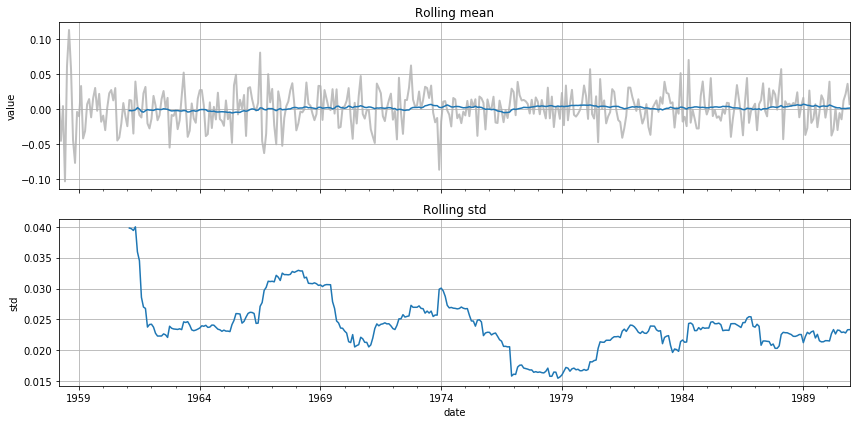

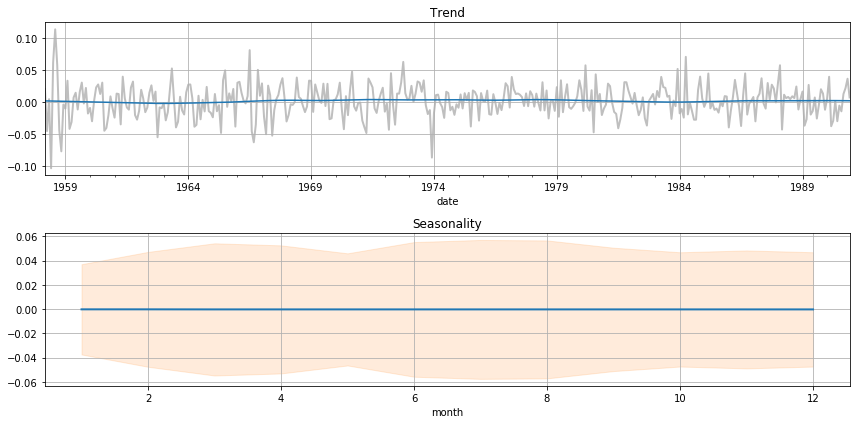

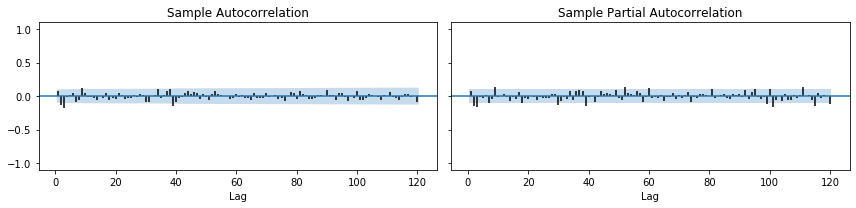

{'ADF': (-14.448463043253248, 4.742949335579849e-22),
 'KPSS': (0.224828042512957, 0.1)}

In [54]:
diagnostics(exp_smooth_fitted.resid, window=36, lags=120)

The quantile-quantile Q-Q plot indicates that the residuals distribution has "heavy tails", rather because of the unstable variance.

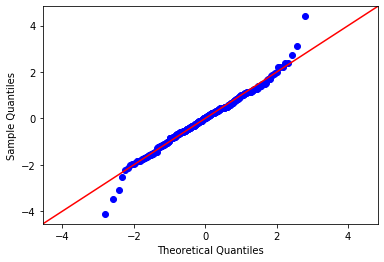

In [55]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

qqplot(exp_smooth_fitted.resid, fit=True, line='45');

Do not forget that we have applied transformations to the series

In [56]:
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()

series_fitted = transformer.inverse_transform(series_fitted)

fitted_holt_winters = pd.Series(series_fitted.ravel(),
                                name=target_column,
                                index=dataset.index)

Let's look at the approximation

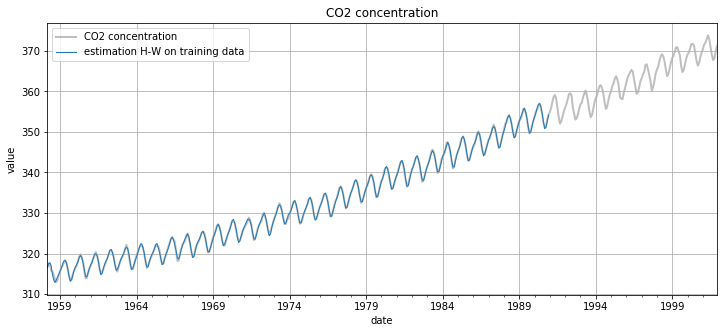

In [57]:
# create and customize the figures: left and right
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=.25, zorder=-10)

fitted_holt_winters.plot(ax=ax, color="C0", lw=1, alpha=1.0,
                         label="estimation H-W on training data")

ax.grid(which="major", axis="both")
ax.legend() ;


Let's look at the residuals in the training sample

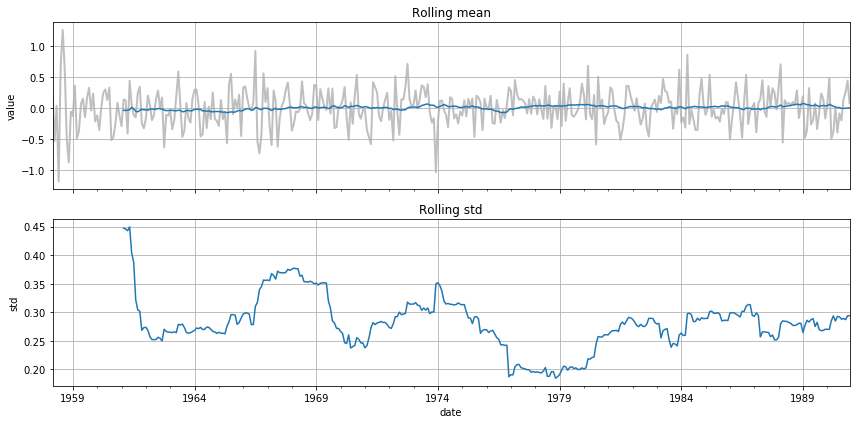

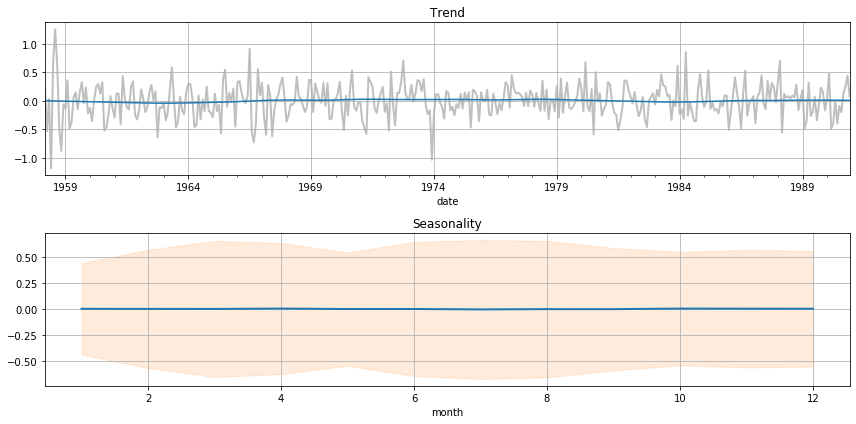

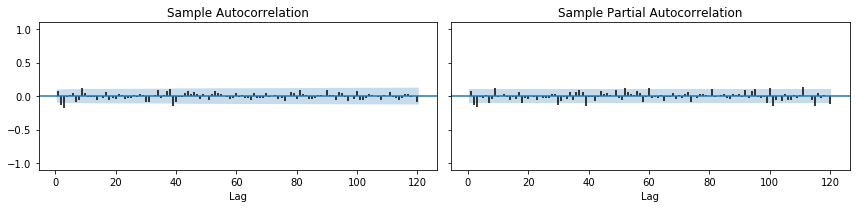

{'ADF': (-14.247238341680607, 6.754184753747523e-22),
 'KPSS': (0.21559273813208993, 0.1)}

In [58]:
residuals = dataset[target_column] - fitted_holt_winters

diagnostics(residuals, window=36, lags=120)

Construct a quantile-quantile Q-Q plot for residuals at the original scale

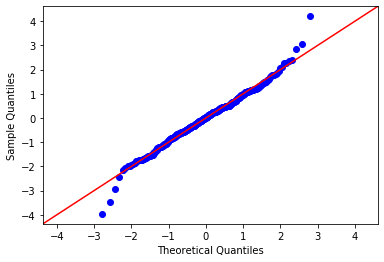

In [59]:
qqplot(residuals, fit=True, line='45');

Judging by sample autocorrelations residuals series are very similar to stationary ones

* no autocorrelations left
* there is no deterministic or stochastic trend

**CONCLUSION** The exponential smoothing model can be **useful** for predicting this process.

### B. Validation of the time series model 

#### Forecasting

**Aim** -- build a trajectory of future values forecasts on the $h$ horizon based on available information at the time of $t$ *inclusive*.

* If **exogenous** variables are involved in the time series model, it is necessary to **know future trajectory** of exogenous variables $x_{t+h},\,x_{t+h-1},\,\ldots$
  - forecasts $x_t$ from other models (which should not use $y_t$)

#### Dynamic or out-of-sample

Forecasts $\hat{y}_{s\mid t}$ for $s = t+1,\,\ldots,\, t+h$ calculated by

* trajectories of **exogenous** variables up to moment $s$ *including* the moment $s$ ($x_s,\,x_{s-1},\,\ldots$)

* the history of predictions $\hat{y}_{j\mid t}$ for $j = s-1,\,\ldots,\,t,\,t-1,\,\ldots$, with $\hat{y}_{j\mid t} = y_j$ if $j\leq t$ -- the actual historical value is used.

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \color{blue}{\hat{y}_{t+1\mid t}}
  , \color{gray}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \color{blue}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
        , \hat{y}_{t+2\mid t}
        , \ldots
        , \hat{y}_{t+h-1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \hat{y}_{t+2\mid t}
  , \ldots
  , \hat{y}_{t+h-1\mid t}
  , \color{blue}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

#### Static or in-sample

Calculate sequential one-step dynamic forecasts
$\tilde{y}_s = \hat{y}_{s\mid s-1}$ for $s=t+1,\,\ldots,\,t+h$

- must be available **trajectory values** of endogenous variables $y_t$ (*actual*);
Useful
- to validate a pre-trained model on a known dataset

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
      }}^{\color{blue}{\hat{y}_{t+1\mid t}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , \color{red}{y_{t+1}}
  , \color{gray}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
      }}^{\color{blue}{\hat{y}_{t+2\mid t+1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , \color{red}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
        , y_{t+2}
        , \ldots
        , y_{t+h-1}
      }}^{\color{blue}{\hat{y}_{t+h\mid t+h-1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , y_{t+2}
  , \ldots
  , y_{t+h-1}
  , \color{red}{y_{t+h}}
  , \ldots
\end{aligned}

We will validate the forecast using these metrics:

$$
    MSE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
\,. $$

In [60]:
from sklearn.metrics import mean_squared_error

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

In [61]:
def root_mean_squared_error(*args, **kwargs):
    return np.sqrt(mean_squared_error(*args, **kwargs))

$$
    MAE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m \bigl\lvert y_i - \hat{y}_i \bigr\rvert
\,. $$

In [62]:
from sklearn.metrics import mean_absolute_error

$$
    \text{Median-AE}(y, \hat{y})
        = \text{median}\bigl\{
            \lvert y_1 - \hat{y}_1\rvert
            ,\, \ldots ,\,
            \lvert y_m - \hat{y}_m\rvert \bigr\}
\,. $$

In [63]:
from sklearn.metrics import median_absolute_error

$$ 
    MAPE(y, \hat{y})
        = \frac1{m} \sum_{i=1}^m
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

In [64]:
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\sum_{i=1}^m (y_i - \bar{y})^2}
\,. $$

In [65]:
from sklearn.metrics import r2_score

$$
    \text{Explained Variance}(y, \hat{y})
        = 1 - \frac{\mathop{var}(y - \hat{y})}{\mathop{var}(y)}
\,. $$

In [66]:
from sklearn.metrics import explained_variance_score

All metrics in the list below

In [67]:
scorers = [
    ("expl-var", explained_variance_score),
    ("mse", mean_squared_error),
    ("rmse", root_mean_squared_error),
    ("mae", mean_absolute_error),
    ("median-ae", mean_absolute_error),
    ("r2", r2_score),
    ("mape", mean_absolute_percent_error)
]

Let's look at the **dynamic** forecast for $240$ months ahead

In [68]:
# Get a forecast for future 240 months
exp_forecast = exp_smooth_fitted.forecast(steps=240).to_frame()

exp_forecast = pd.DataFrame(transformer.inverse_transform(exp_forecast),
                            columns=exp_forecast.columns,
                            index=exp_forecast.index)

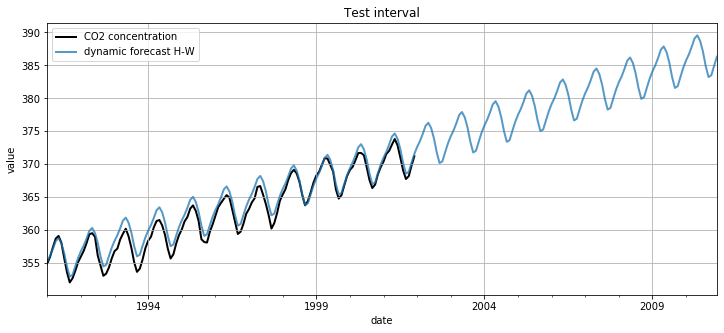

In [69]:
# create and customize the figures
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title="Test interval")

# plot the dynamics
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

exp_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast H-W")

ax.grid(which="major", axis="both")
ax.legend()

Calculate metrics

In [70]:
holdout_exp_smooth_score_values = pd.Series({
    name: metric(holdout[target_column],
                 exp_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [71]:
holdout_exp_smooth_score_values

expl-var     0.985447
mse          1.451867
rmse         1.204934
mae          1.045363
median-ae    1.045363
r2           0.953117
mape         0.289338
dtype: float64

Compare with the simplest baseline -- **forecast by the last known value**

In [72]:
last_known_forecast = full_dataset.shift(1).loc[holdout_slice]

holdout_last_known_score_values = pd.Series({
    name: metric(holdout[target_column], last_known_forecast[target_column])
    for name, metric in scorers
})

In [73]:
holdout_last_known_score_values

expl-var     0.948025
mse          1.626034
rmse         1.275161
mae          1.141212
median-ae    1.141212
r2           0.947493
mape         0.315076
dtype: float64

### Validation of the time series model

Sliding validation forward in time:

1 . consecutive **leave-one-out**:

  - fit the model, predict one future observation, shift to one observation
  
2 . consecutive $k$-**fold**:

  - split the sample into $k$ consecutive blocks **without** mixing

  - fit the model, predict the entire next block, moving one block forward  

Length of the training sample during validation

- a fixed number of observations $w$ in the training sample $(x_s, y_s)_{s=t+1-w}^t$ -- *(rolling window)*

- the training sample contains the entire history of observations $(x_s, y_s)_{s \leq t}$ -- *(rolling prediction origin)*

#### One-step with a fixed-length training sample

<img src="./figures/in-sample.png" title="одношаговая валидация с фиксированным окном"
alt="https://blog.cadre.com/how-cadre-uses-machine-learning-to-target-real-estate-markets-3c03ca1dac26">

#### $k$-fold with a growing training sample

`Scikit-learn` has a procedure for $k$-fold fold validation of a time series with a **growing training sample**

<img src="./figures/ts-k-fold.png" title="k-fold кроссвалидация временных рядов"
alt="https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection">

Resources: https://habr.com/ru/company/ods/blog/327242/ 

In [74]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=20, max_train_size=None)

Let's use convenient functions from `scikit` to index `pandas`  matrices and copy models

In [75]:
from sklearn.utils import safe_indexing

from sklearn.base import clone

Validate the model

In [76]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split into train and test
    cv_train = safe_indexing(dataset, train_ix)

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. fit the model
    cv_model = ExponentialSmoothing(cv_train[target_column], trend="add",
                                    seasonal="add", seasonal_periods=12)
    cv_model = cv_model.fit()

    # 3. building a forecast
    cv_test = safe_indexing(dataset, test_ix)
    cv_forecast = cv_model.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

tscv_exp_smooth_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

20it [00:03,  6.08it/s]


Put the forecasts in a series and plot them

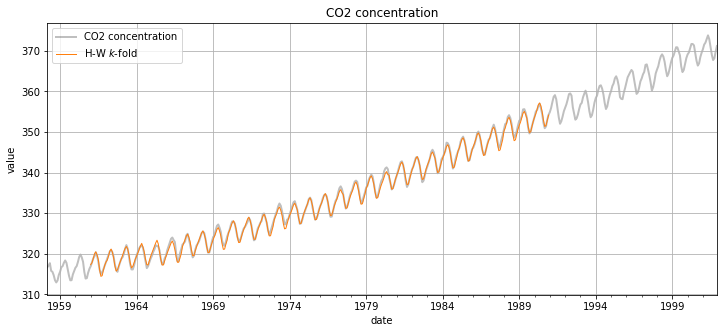

In [77]:
# create and customize the figures
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_exp_smooth_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                             label="H-W $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;

Calculate metrics on " test intervals"

In [78]:
has_forecast = tscv_exp_smooth_forecast.isnull().any(axis=1)

exp_smooth_score_values = pd.DataFrame.from_dict({
    name: metric(dataset.loc[~has_forecast],
                 tscv_exp_smooth_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [79]:
exp_smooth_score_values

,expl-var,mse,rmse,mae,median-ae,r2,mape
CO2 concentration,0.998298,0.254045,0.504029,0.386008,0.386008,0.998025,0.115955


Compare with the baseline on the training folds

In [80]:
last_known_forecast = dataset.shift(1)

has_forecast = last_known_forecast.isnull().any(axis=1)

last_known_score_values = pd.DataFrame.from_dict({
    name: metric(dataset.loc[~has_forecast],
                  last_known_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [81]:
last_known_score_values

,expl-var,mse,rmse,mae,median-ae,r2,mape
CO2 concentration,0.990532,1.346114,1.160221,1.031462,1.031462,0.990467,0.310652


<br>

# <span style="color:blue;">**Seminar 3**</span>

   
#### Seminar 3. 
    
4. Building an autoregression model and moving average model
    
    
5. Reducing the data dimension
    1. Singular spectral decomposition
    

6. Comparison of predictive models
    

## 4. Building an autoregression model and moving average model

Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving Average (SARIMA), 
the second model requires selecting hyperparameters for both trend and seasonal elements of the series.


Read here: [seasonality in the autoregressive models](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

In [82]:
from statsmodels.tsa.arima_model import ARIMA

* $\phi(\cdot)$ и $\theta(\cdot)$ -- "the lag polynomials" do not have common roots

* $\phi(\cdot)$ does not have single roots

* $\varepsilon_t$ -- white noise, i.e. has zero mean, constant variance, and zero autocorrelations.

The $ARIMAX(p, d, q)$ process with exogenous variables has the form

\begin{align}
    y_t &= \overbrace{\mu + x_t \beta}^{\tau_t}+ \delta_t
        \,, \\
    (1 - L)^d \, \delta_t &= u_t
        \,, \\
    \underbrace{\Bigl(1 - \sum_{k=1}^p \phi_k L^k \Bigr)}_{\phi(L)}
        \, u_t &= \mu + \underbrace{\Bigl( 1 + \sum_{k=1}^q \theta_k L^k \Bigr)}_{\theta(L)}
        \, \varepsilon_t
        \,,
\end{align}

where $L$ -- shift operator back one step in the past, i.e. $L\, y_t = y_{t-1}$

The $ARIMAX(p, d, q)$ process with exogenous variables has the form

    p: the number of autoregressive lags included in the model
    d: the degree of differencing 
    q: the number of moving average lags

\begin{align}
    y_t &= \overbrace{\mu + x_t \beta}^{\tau_t}+ \delta_t
        \,, \\
    (1 - L)^d \, \delta_t &= u_t
        \,, \\
    \underbrace{\Bigl(1 - \sum_{k=1}^p \phi_k L^k \Bigr)}_{\phi(L)}
        \, u_t &= \mu + \underbrace{\Bigl( 1 + \sum_{k=1}^q \theta_k L^k \Bigr)}_{\theta(L)}
        \, \varepsilon_t
        \,,
\end{align}

where $L$ -- shift operator back one step in the past, i.e. $L\, y_t = y_{t-1}$

* $\phi(\cdot)$ and $\theta(\cdot)$ -- "the lag polynomials" do not have common roots

* $\phi(\cdot)$ does not have single roots

* $\varepsilon_t$ -- white noise, i.e. has zero mean, constant variance, and zero autocorrelations.

#### ARIMA model evaluation strategy (Box-Jenkins)

1. Check the assumptions about stationarity, and find the transformations that bring the series to stationary view.

2. Using autocorrelation diagnostics, determine the order of lags in the AR (`pacf`)and MA (`acf`) parts.  Estimate the seasonality.

3. Among reasonable combinations of parameters, choose the model with the lowest criterion **BIC** or **AIC**.

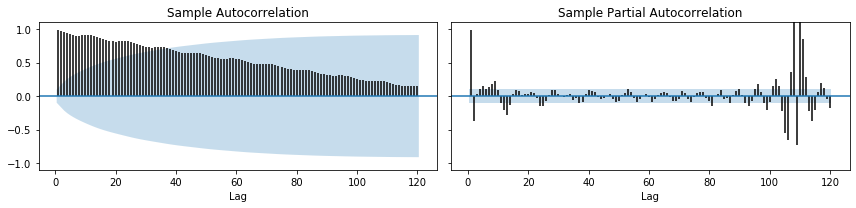

In [87]:
correlation_diagnostics(train, lags=120) ;

* autocorrelation of small lags is close to $1.0$ and decreases quite slowly
* there are suspicious fluctuations

Perhaps, there is a single root $y_t = y_{t-1} + \ldots$.

Train the model ARIMA $(0, 1, 0)$

In [88]:
model_010 = ARIMA(train, order=(0, 1, 0))

model_010_fitted = model_010.fit(disp=0)

Let's look at its residuals in the training sample (and in differences)

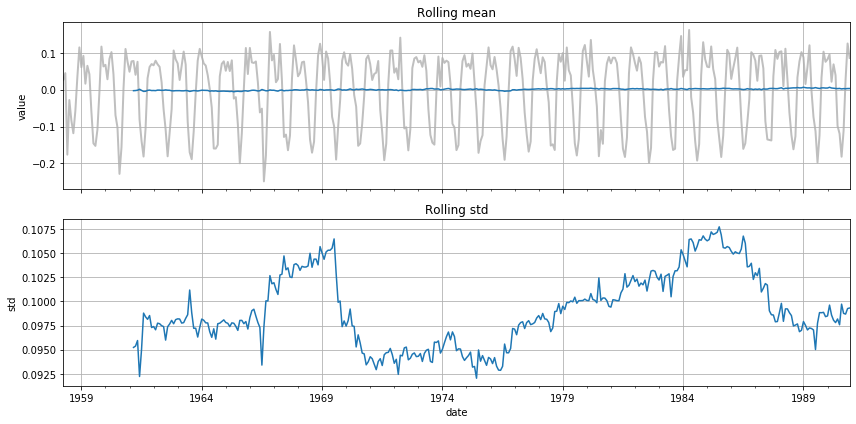

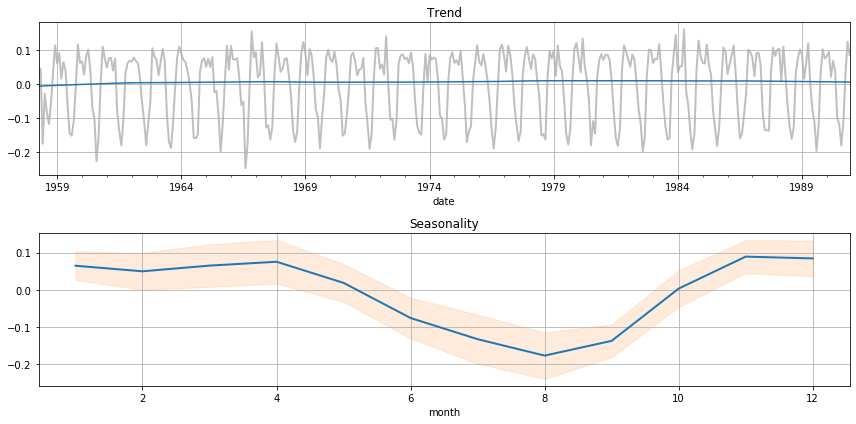

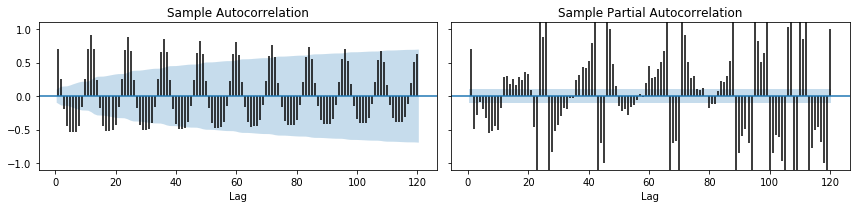

{'ADF': (-4.805363820003886, 0.0004583714420923736),
 'KPSS': (0.05248524692466152, 0.1)}

In [89]:
diagnostics(model_010_fitted.resid, window=36, lags=120)

* Slow decrease of periodic ($12$) peaks indicates seasonal dependence of the form $y_t = y_{t-12} + \ldots$

The data seems to correlate with each other monthly, but also their level depends on the value of $12$ months ago.

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

The SARIMA$(p, d, q)\times (P, D, Q)_{s}$ process has the form

\begin{align}
    (1 - L)^d \, (1 - L^s)^D \, y_t &= u_t
        \,, \\
    \Bigl(1 - \sum_{j=1}^p \phi_k L^j\Bigr)
        \, \Bigl(1 - \sum_{j=1}^P \tilde{\phi}_k L^{s j}\Bigr)
        \, u_t &= \mu \, +
        \, \Bigl(1 + \sum_{j=1}^q \theta_k L^j\Bigr)
        \, \Bigl(1 + \sum_{j=1}^Q \tilde{\theta}_k L^{s j}\Bigr)
        \, \varepsilon_t
        \,.
\end{align}

Let's look at its residuals in the training sample for different model orders

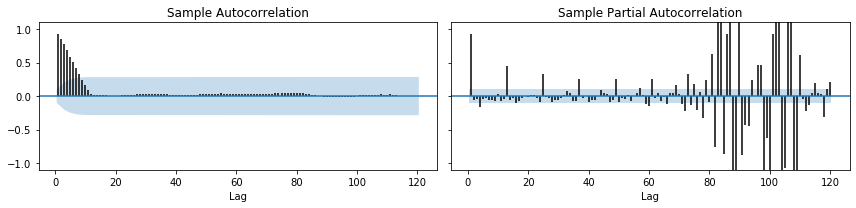

In [91]:
model_sarima_000_010_12 = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_000_010_12_fitted = model_sarima_000_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_000_010_12_fitted.resid, lags=120) ;

* While taking the residuals $y_t - y_{t-12}$, it seems that there are traces of the usual unit root

Let's observe the model
$$ 
    (1 - L^{12})(1 - L) y_t
        = \bigl[y_{t} - y_{t-1} - y_{t-12} + y_{t-13}\bigr]
        = \mu + \varepsilon_t
    \,,$$

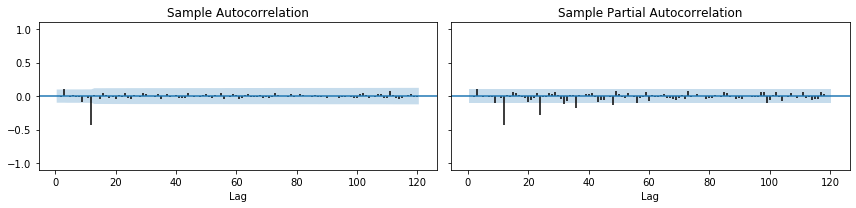

In [93]:
model_sarima_010_010_12 = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12),
                         
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_010_010_12_fitted = model_sarima_010_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_010_010_12_fitted.resid, lags=120) ;

* apparently there are non-zero effects from the moving average

Add the moving average to the seasonal and regular parts.

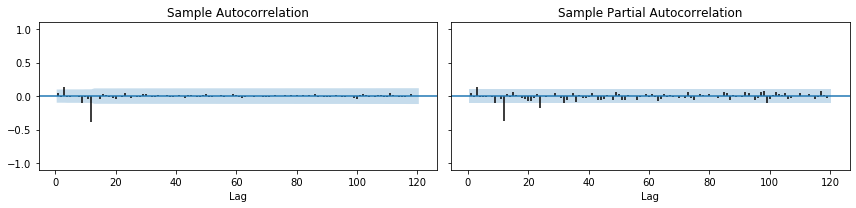

In [94]:
model_sarima_011_011_12 = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_011_011_12_fitted = model_sarima_011_011_12.fit(disp=0)

# diagnostics(model_sarima_011_011_12_fitted.resid, window=36, lags=120) ;
correlation_diagnostics(model_sarima_011_011_12_fitted.resid, lags=120) ;

It seems almost all lags are taken into account... Let's try to weaken the unit roots

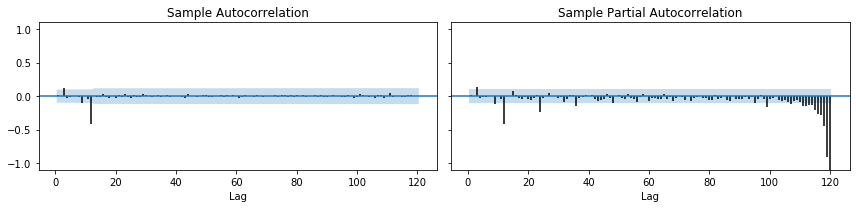

In [97]:
model_sarima_101_101_12 = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)

model_sarima_101_101_12_fitted = model_sarima_101_101_12.fit(disp=0)

# diagnostics(model_sarima_101_101_12_fitted.resid, window=36, lags=120) ;
correlation_diagnostics(model_sarima_101_101_12_fitted.resid, lags=120) ;

Let's return unit roots

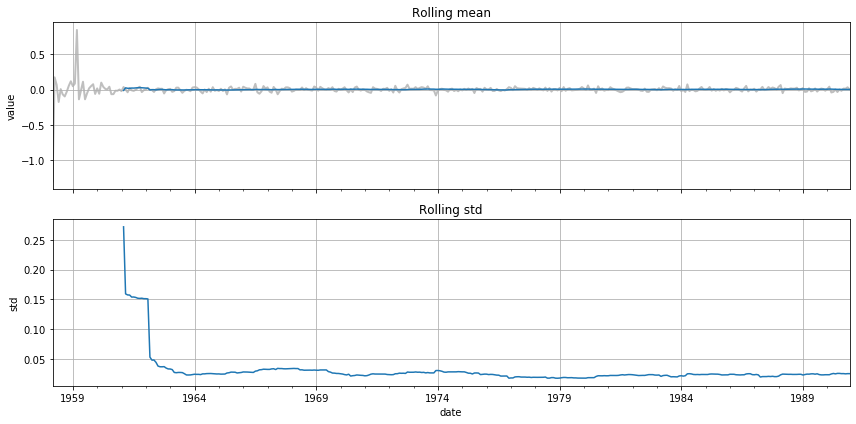

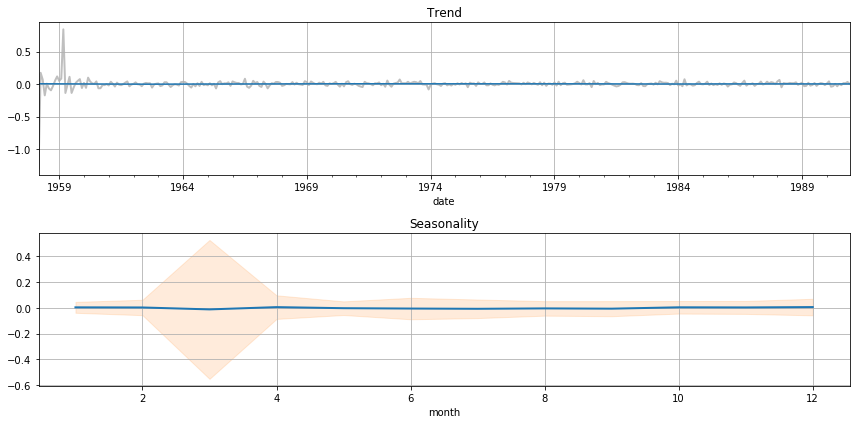

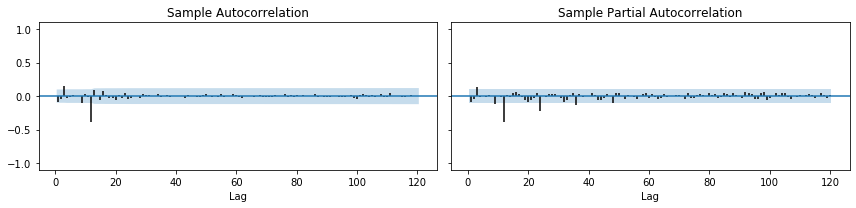

In [98]:
model_sarima_111_111_12 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)

model_sarima_111_111_12_fitted = model_sarima_111_111_12.fit(disp=0)

diagnostics(model_sarima_111_111_12_fitted.resid, window=36, lags=120) ;
# correlation_diagnostics(model_sarima_111_111_12_fitted.resid, lags=120) ;

Judging by sample autocorrelations a residuals series are very similar to stationary ones
* there are no autocorrelations left
* there is no deterministic or stochastic trend

**CONCLUSION** The SARIMA$(1,1,1)\times(1,1,1)_{12}$ model can be **useful** for this process forecasting.

Try a more complex model...

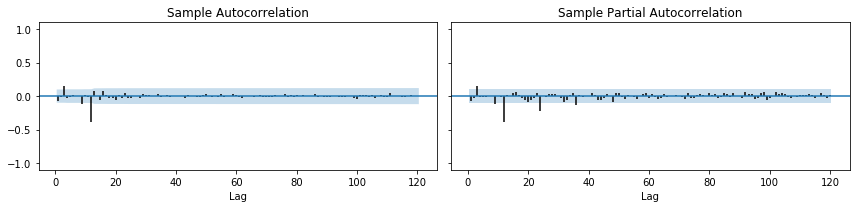

In [99]:
model_sarima_211_111_12 = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)

model_sarima_211_111_12_fitted = model_sarima_211_111_12.fit(disp=0)

# diagnostics(model_sarima_211_111_12_fitted.resid, window=36, lags=120) ;
correlation_diagnostics(model_sarima_211_111_12_fitted.resid, lags=120) ;

Select the model with the lowest **BIC** value (Bayesian information criterion)

Read here: [information criterion](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9)

In [100]:
models = [
  model_010_fitted,
  model_sarima_000_010_12_fitted,
  model_sarima_010_010_12_fitted,
  model_sarima_011_011_12_fitted,
  model_sarima_101_101_12_fitted,
  model_sarima_111_111_12_fitted,
  model_sarima_211_111_12_fitted,
]

[getattr(mdl, "bic") for mdl in models]

[-701.6084650084114,
 -559.8258662873744,
 -1440.907985973128,
 -1623.8069925448867,
 -1562.372342595391,
 -1641.8968093393926,
 -1636.5235618789916]

In [101]:
sarima_fitted = models[5]

The quantile-quantile Q-Q graph shows the residuals have an approximately normal distribution.

* the first 24 observations were dropped due to the "edge" effects of the sample start

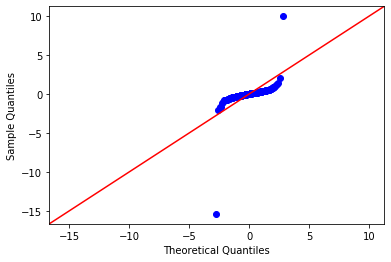

In [102]:
qqplot(sarima_fitted.resid[:], fit=True, line='45');

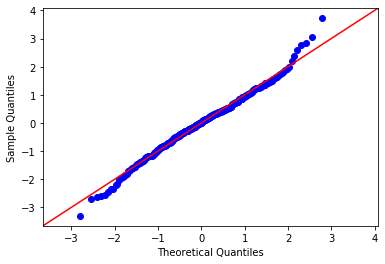

In [103]:
# build the central part
qqplot(sarima_fitted.resid[20:], fit=True, line='45');

The `SARIMAX` returns the fitted values on the training sample in the `fittedvalues`:
* the series corresponds to the prediction in the original data values (**NOT* * in residuals like in `ARIMA`)

In [104]:
if isinstance(sarima_fitted.model, SARIMAX):
    series_fitted = sarima_fitted.fittedvalues.to_frame()

elif isinstance(sarima_fitted.model, ARIMA):
    series_fitted = np.concat([
        train.iloc[:1],             # add a little history (for integration)
        sarima_fitted.fittedvalues,  # add fitted values
    ], axis=0).cumsum(axis=0)

Inverse transformation

In [105]:
series_fitted = transformer.inverse_transform(series_fitted)

fitted_arima = pd.Series(series_fitted.ravel(),
                         name=target_column,
                         index=dataset.index)

Look at the fitting plot

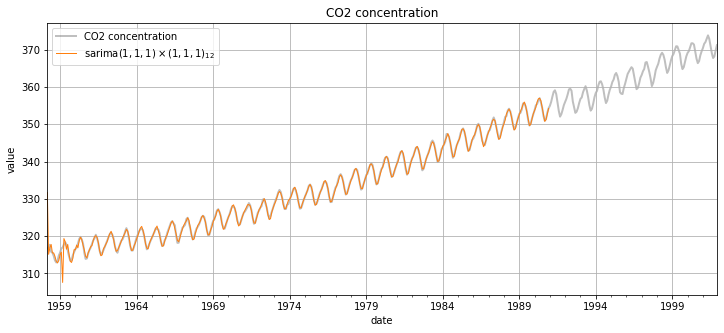

In [108]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

fitted_arima.plot(ax=ax, color="C1", lw=1, alpha=1.0,
                  label="sarima$(1,1,1)\\times(1,1,1)_{12}$")

ax.grid(which="major", axis="both")
ax.legend() ;


Let's look at the **dynamic** forecast for $240$ months ahead

In [109]:
# Get a forecast for future 240 months
sarima_forecast = sarima_fitted.forecast(steps=240).to_frame()

sarima_forecast = pd.DataFrame(transformer.inverse_transform(sarima_forecast),
                            columns=sarima_forecast.columns,
                            index=sarima_forecast.index)

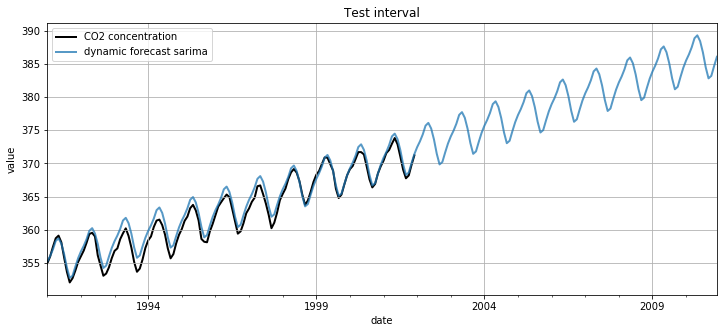

In [112]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title="Test interval")

# draw the dynamics
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

sarima_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast sarima")

ax.grid(which="major", axis="both")
ax.legend() ;

Calculate metrics

In [113]:
holdout_sarima_score_values = pd.Series({
    name: metric(holdout[target_column],
                 sarima_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [114]:
holdout_sarima_score_values

expl-var     0.985492
mse          1.146254
rmse         1.070632
mae          0.909481
median-ae    0.909481
r2           0.962986
mape         0.251873
dtype: float64

Validate the model

In [115]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split into train and test
    cv_train = safe_indexing(dataset, train_ix)

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. fit the model
    cv_model = SARIMAX(cv_train[target_column],
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

    try:
        cv_model_fitted = cv_model.fit(disp=0)
    except ValueError:
        continue

    # 3. building a forecast
    cv_test = safe_indexing(dataset, test_ix)
    cv_forecast = cv_model_fitted.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

20it [00:23,  1.18s/it]


Unfortunately, due to the sample shortage, sometimes SARIMA fitting is inadequate (on series with a short history).

In [116]:
raw_forecast[np.nan_to_num(raw_forecast) <= 0] = np.nan

raw_forecast[~np.isfinite(raw_forecast)] = np.nan

tscv_sarima_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

Put the predictions in a series and plot them

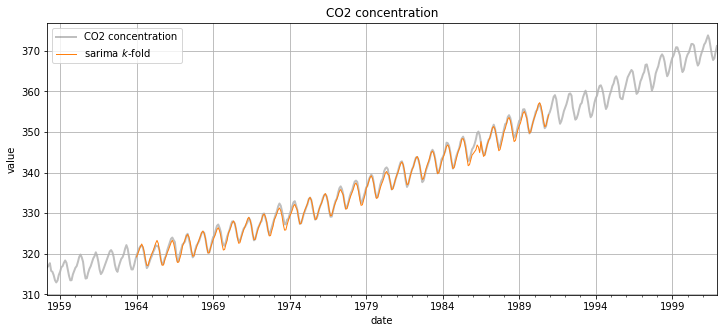

In [117]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series and predictions
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_sarima_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                         label="sarima $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Calculate metrics using "test intervals"

In [118]:
has_forecast = tscv_sarima_forecast.isnull().any(axis=1)

sarima_score_values = pd.DataFrame.from_dict({
    name: metric(dataset.loc[~has_forecast],
                 tscv_sarima_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [119]:
sarima_score_values

,expl-var,mse,rmse,mae,median-ae,r2,mape
CO2 concentration,0.996647,0.485965,0.697112,0.489775,0.489775,0.995757,0.14572


## 5.  Reducing the data dimension

#### A.  Singular spectral decomposition

This method is based on reducing the dimension of the time series special representation

+ **+** works well with multidimensional data
+ **-** requires explicitly specification of the number of hidden factors
+ **-** selected hidden factors must be modeled separately

In [39]:
n_embedding, n_components = 12, 4

n_samples, n_targets = dataset.shape

For this method, we need to "pack" series into a "snake"

* Direct transformation for building a $Y_t$ matrix based on a series $(y_s)_{s=1}^t$:

\begin{equation}
    y_1,\,,\ldots,\,y_{t-1},\,y_t
    \quad \mapsto
    \quad Y_t =
        \begin{pmatrix}
            y_1                 & \color{orange}{y_2} & \color{red}{y_3}  & \cdots & y_p     \\
            \color{orange}{y_2} & \color{red}{y_3}    & \color{blue}{y_4} & \cdots & y_{p+1} \\
            \color{red}{y_3}    & \color{blue}{y_4}   & y_5               & \cdots & y_{p+2} \\
            \vdots              & \vdots              & \vdots            & \ddots & \vdots  \\
            y_{t-p+1}           & y_{t-p+2}           & y_{t-p+3}         & \cdots & y_t     
        \end{pmatrix}
\end{equation}

In [121]:
def embed_transform(X, n_embedding):
    # lags from n_lags - 1 to 1
    n_lags = n_embedding - 1
    lagged = [X[k:k - n_lags] for k in range(n_lags)]

    # current value

    lagged.append(X[n_lags:])

    # join and return
    embed = np.stack(lagged, axis=1)
    return embed.reshape(len(X) - n_lags, -1)

* Inverse transformation: calculate the average for all anti-diagonals of the matrix $X_t$

* Anti-diagonals in the *lower-right corner*  may be "incomplete"

\begin{equation}
    X_t
    = \begin{pmatrix}
        x^1_p         & \color{orange}{x^{(2)}_p}     & \color{red}{x^{(3)}_p}     & \cdots & x^{(p)}_p     \\
        \color{orange}{x^{(1)}_{p+1}} & \color{red}{x^{(2)}_{p+1}} & \color{blue}{x^{(3)}_{p+1}} & \cdots & x^{(p)}_{p+1} \\
        \color{red}{x^{(1)}_{p+2}} & \color{blue}{x^{(2)}_{p+2}} & x^{(3)}_{p+2} & \cdots & x^{(p)}_{p+2} \\
        \vdots        & \vdots        & \vdots        & \ddots & \vdots        \\
        x^{(1)}_t     & x^{(2)}_t     & x^{(3)}_t     & \cdots & x^{(p)}_t
    \end{pmatrix}
    \quad \mapsto
    \quad \tfrac1{p} \sum_{j=0}^{p-1} \color{red}{x^{(p-j)}_{s+j}}
    \,, s=p,\,\ldots,\,t
\end{equation}

In [122]:
def embed_inverse_transform(X, n_targets):
    assert (X.shape[1] % n_targets) == 0

    result = np.zeros((len(X), n_targets), dtype=float)
    for k in range(n_targets):
        # select the k-th feature
        X_k = X[:, k::n_targets]
        n_embedding = X_k.shape[1]

        # calculate the average for all anti-diagonals (even incomplete ones!)
        result[:, k] = np.array([
            np.diag(X_k[j:j + n_embedding, ::-1]).mean()
            for j in range(len(X))
        ])
    return result

1) Direct transformation creates a $Y_t$ matrix from a series $y_t$

In [123]:
data_Y = embed_transform(train, n_embedding)

# np.round(data_Y[:4], 2)  #  check the structure correctness

# np.allclose(embed_inverse_transform(data_Y, n_targets), train.values[n_embedding-1:, -1:])

2) Select $m < p$ hidden factors $f_s = (f^{(1)}_s,\,\ldots,\,f^{(m)}_s)$

\begin{equation}
    F_t
    = \begin{pmatrix}
        f^{(1)}_p        & \cdots & f^{(m)}_p      \\
        f^{(1)}_{p+1}    & \cdots & f^{(m)}_{p+1}  \\
        \vdots           & \ddots & \vdots         \\
        f^{(1)}_t        & \cdots & f^{(m)}_t
    \end{pmatrix}
\end{equation}

  * the **PCA** methods searches for $m$-dimensional linear transformation of data into factors:

    - low approximation error: $y_{s+j} \approx \sum_{k=1}^m f^{(k)}_s v_{kj}$
    for all where $s=1\,,\ldots\,,t-p+1$ and $j=0,\,\ldots,\,p-1$

    - the transformation components are linearly independent and pairwise orthogonal

In [124]:
from sklearn.decomposition import PCA

ssa = PCA(n_components=n_components)

data_F = pd.DataFrame(ssa.fit_transform(data_Y), index=dataset.index[n_embedding - 1:])

Typical situation for methods based on calculating eigenvectors:
* select components ordered by frequency

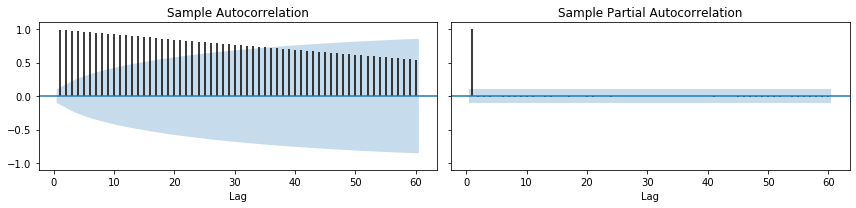

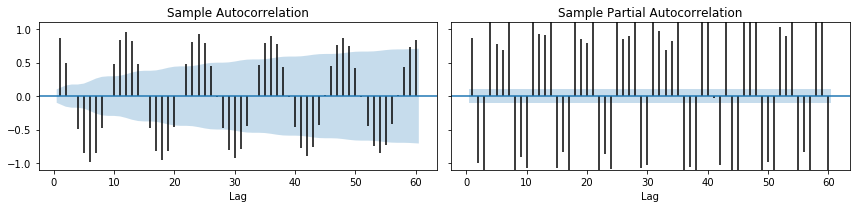

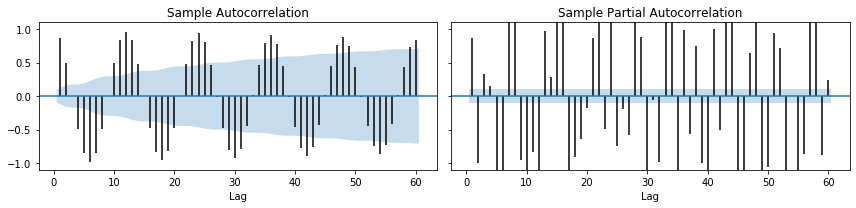

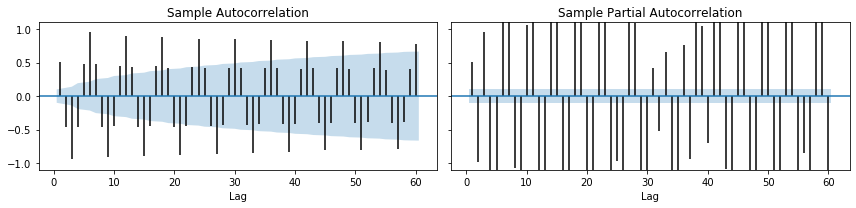

In [125]:
for j in range(ssa.n_components_):
    correlation_diagnostics(data_F[j]) ;

Apply the inverse transformation of factors on the training sample

In [126]:
data_fitted = ssa.inverse_transform(data_F)

ssa_fitted = embed_inverse_transform(data_fitted, n_targets)

ssa_fitted = pd.DataFrame(ssa_fitted, index=data_F.index, columns=dataset.columns)

Let's look at the residuals

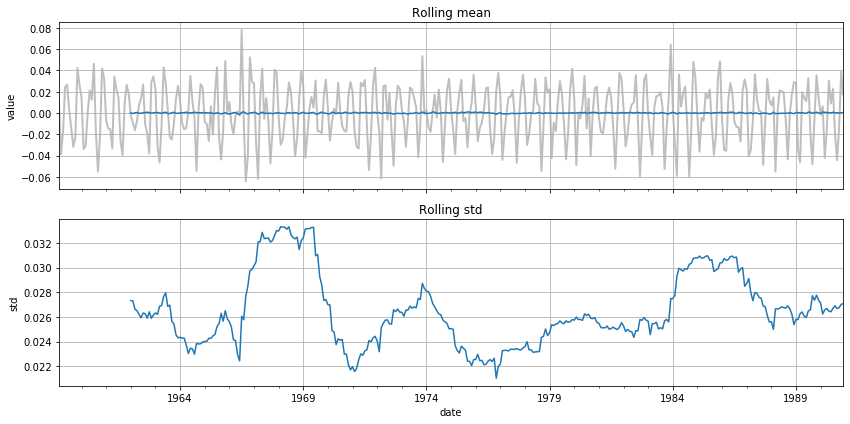

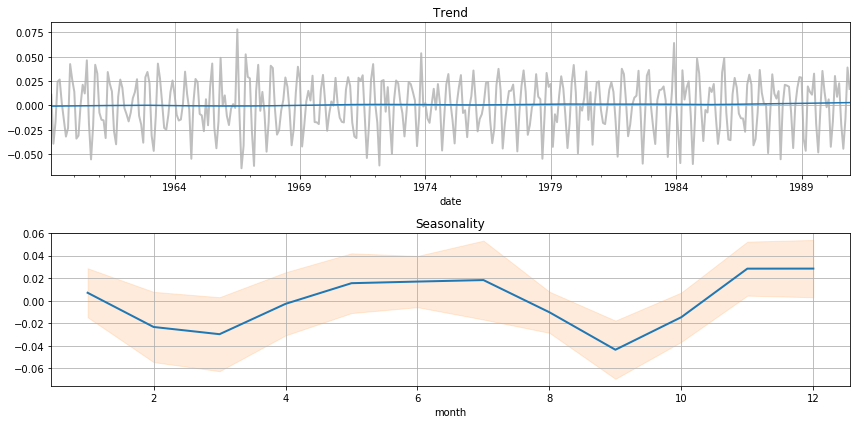

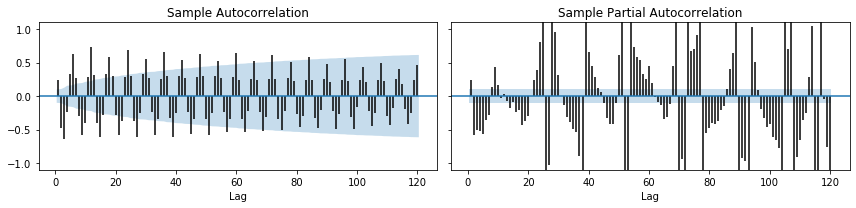

{'ADF': (-8.259302392812696, 1.7983799853250704e-11),
 'KPSS': (0.08329462599832423, 0.1)}

In [127]:
ssa_residuals = train[target_column].iloc[-len(ssa_fitted):] - ssa_fitted[target_column]

diagnostics(ssa_residuals, window=36, lags=120)

3)  On the series of the $j$ hidden factor $f^{(j)}_s$ where $s=p,\,p+1,\,\ldots,\,t$ we train the time series model
* we use the Holt-Winters method

In [131]:
models = []
for j in range(ssa.n_components_):
    exp_mod = ExponentialSmoothing(data_F[j], trend="add", seasonal="add",
                                   seasonal_periods=12)
    models.append(exp_mod.fit(remove_bias=True))

4) Predict the hidden factors for $240$ months ahead

In [132]:
n_horizon = 240

latent_pred = pd.concat([
    mdl.forecast(n_horizon) for mdl in models
], axis=1)

Let's look at the forecasts

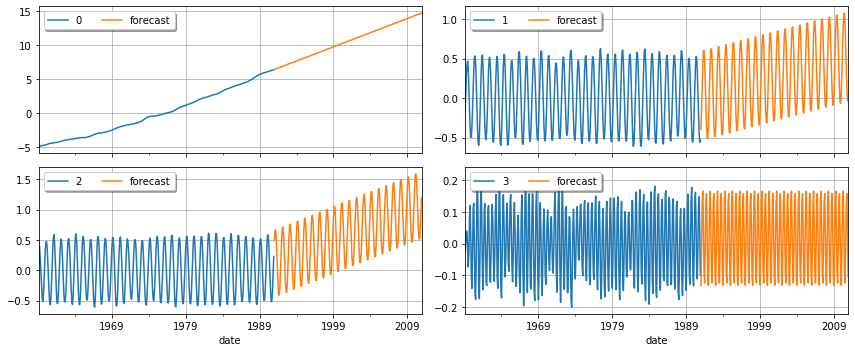

In [133]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(nrows=2, ncols=2, sharex=True)

for (col, ser), ax in zip(data_F.items(), axes.ravel()):
# draw the dynamics of hidden factors
    ser.plot(ax=ax, color="C0")
    latent_pred[col].plot(ax=ax, color="C1", label="forecast")

    ax.grid(which="major", axis="both")
    ax.legend(loc="upper left", ncol=2, shadow=True)

fig.tight_layout() ;

Plot forecasts for the original series

In [134]:
ssa_forecast = ssa.inverse_transform(latent_pred)

# inverse transformation
ssa_forecast = embed_inverse_transform(ssa_forecast, n_targets)

ssa_forecast = transformer.inverse_transform(ssa_forecast)

ssa_forecast = pd.DataFrame(ssa_forecast, index=latent_pred.index,
                            columns=["прогноз "+ col for col in dataset.columns])

Plot it

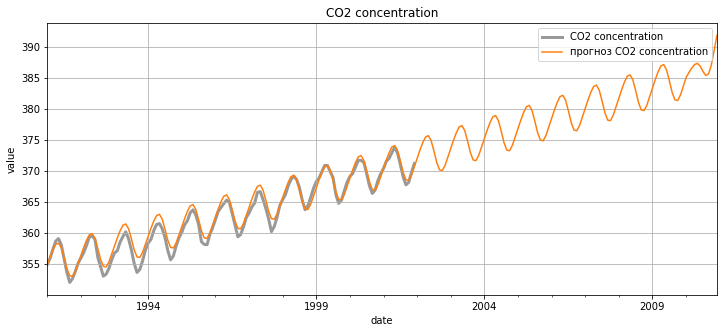

In [135]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series
holdout[target_column].plot(ax=ax, color="black", lw=3, alpha=.4, zorder=-10)

ssa_forecast.plot(ax=ax, color="C1", lw=1.5)

ax.grid(which="major", axis="both")
ax.legend() ;


Calculate metrics

In [136]:
holdout_ssa_score_values = pd.Series({
    name: metric(holdout[target_column],
                 ssa_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [137]:
holdout_ssa_score_values

expl-var     0.981755
mse          0.988422
rmse         0.994194
mae          0.824258
median-ae    0.824258
r2           0.968083
mape         0.228246
dtype: float64

Validate the model

In [138]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split into train and test
    cv_train = safe_indexing(dataset, train_ix)
    cv_train_index = cv_train.index

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer)
    cv_train = cv_transformer.fit_transform(cv_train)

    # 2.1 fit the model: selecting factors
    cv_embed_train = embed_transform(cv_train, n_embedding)

    cv_ssa_model = clone(ssa)
    cv_factors = cv_ssa_model.fit_transform(cv_embed_train)

    cv_factors = pd.DataFrame(cv_factors, index=cv_train_index[n_embedding - 1:])

    # 2.2 fit the model: factors
    try:
        cv_models = []
        for j in range(cv_ssa_model.n_components_):
            cv_exp_mod = ExponentialSmoothing(cv_factors[j],
                                              trend="add", seasonal="add",
                                              seasonal_periods=12)

            cv_models.append(cv_exp_mod.fit(remove_bias=True))
    except ValueError:
        continue

    # 3.1 building a forecast: factors
    cv_test = safe_indexing(dataset, test_ix)

    cv_factors_pred = pd.concat([
        mdl.forecast(len(cv_test)) for mdl in cv_models
    ], axis=1)

    # 3.2 building a forecast: reverse embedding and anti-diagonal averaging
    cv_ssa_forecast = cv_ssa_model.inverse_transform(cv_factors_pred)

    cv_ssa_forecast = embed_inverse_transform(cv_ssa_forecast, n_targets)

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_ssa_forecast)

tscv_ssa_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

20it [00:08,  2.23it/s]


Collect all predictions to a single series and plot them

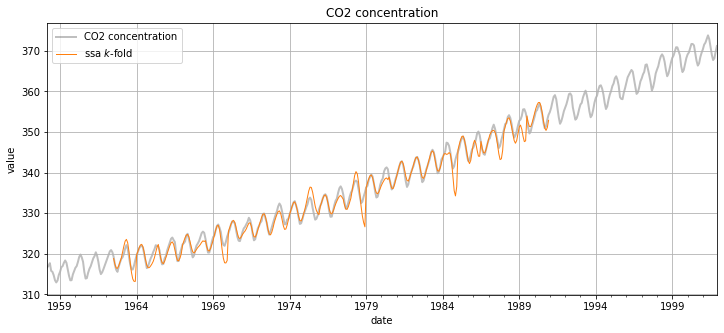

In [139]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series and predictions
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_ssa_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                      label="ssa $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Calculate metrics on "test intervals"

In [140]:
has_forecast = tscv_ssa_forecast.isnull().any(axis=1)

ssa_score_values = pd.DataFrame.from_dict({
    name: metric(dataset.loc[~has_forecast],
                 tscv_ssa_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [141]:
ssa_score_values

,expl-var,mse,rmse,mae,median-ae,r2,mape
CO2 concentration,0.9759,3.194745,1.787385,1.084608,1.084608,0.97395,0.323242


## 6. Comparison of predictive models

Summary table of metrics on holdout

In [142]:
holdout_score_values = pd.concat({
    "last known": holdout_last_known_score_values,
    "Holt-Winters": holdout_exp_smooth_score_values,
    "SARIMA": holdout_sarima_score_values,
    "SSA": holdout_ssa_score_values
}, axis=1)

In [143]:
holdout_score_values.style.background_gradient(axis=1, cmap=plt.cm.RdYlGn_r)

,last known,Holt-Winters,SARIMA,SSA
expl-var,0.948025,0.985447,0.985492,0.981755
mse,1.62603,1.45187,1.14625,0.988422
rmse,1.27516,1.20493,1.07063,0.994194
mae,1.14121,1.04536,0.909481,0.824258
median-ae,1.14121,1.04536,0.909481,0.824258
r2,0.947493,0.953117,0.962986,0.968083
mape,0.315076,0.289338,0.251873,0.228246


Summary table of metrics on cross validation folds

In [144]:
cv_score_values = pd.concat({
    "last known": last_known_score_values,
    "Holt-Winters": exp_smooth_score_values,
    "SARIMA": sarima_score_values,
    "SSA": ssa_score_values
}, axis=1).stack()

In [145]:
cv_score_values.loc[target_column].style.background_gradient(axis=1, cmap=plt.cm.RdYlGn_r)

,last known,Holt-Winters,SARIMA,SSA
expl-var,0.990532,0.998298,0.996647,0.9759
mse,1.34611,0.254045,0.485965,3.19475
rmse,1.16022,0.504029,0.697112,1.78738
mae,1.03146,0.386008,0.489775,1.08461
median-ae,1.03146,0.386008,0.489775,1.08461
r2,0.990467,0.998025,0.995757,0.97395
mape,0.310652,0.115955,0.14572,0.323242
